### Imports


In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn

from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### Data preprocesing

In [38]:
# Importing data
dataset = pd.read_csv('./data/fashion-mnist_train.csv')

# Mapping labels to numbers
labels_mapping = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}
dataset['label_name'] = dataset['label'].map(labels_mapping)

# Data preprocessing
X = dataset.iloc[:, 1 : -1]
Y = dataset.iloc[:, 0]

# Standarization
X_scaled = StandardScaler().fit_transform(X)

# Normalization
X_normalized = normalize(X_scaled)

X = pd.DataFrame(X_normalized)

### Cluster analysis

### Agglomerate Clustering

#### Analysis for the best linkage plus metrics


In [10]:
# Sampling data for computation reasons
dataset_sample = dataset.sample(10000)

# Mapping labels
dataset_sample['label_name'] = dataset_sample['label'].map(labels_mapping)

# Data preprocessing
X_sample = dataset_sample.iloc[:, 1 : -1]
Y_sample = dataset_sample.iloc[:, 0]

# Standarization
X_scaled = StandardScaler().fit_transform(X_sample)

# Normalization
X_normalized = normalize(X_scaled)
X_sample = pd.DataFrame(X_normalized)

In [4]:
# Possible linkages and metrics
linkages = ["ward", "average", "single", "complete"]
metrics = ["euclidean", "manhattan", "cosine", "minkowski"]

clustering_scores = {}
clustering_labels = {}

for metric in metrics:
    for linkage in linkages:
        # For euclidead, ward is the only acceptable
        if linkage == "ward" and metric != "euclidean":
            continue

        # Clustering
        clustering_model = AgglomerativeClustering(
            n_clusters=10,
            metric="euclidean" if linkage == "ward" else metric,
            linkage=linkage
        )

        cluster_labels = clustering_model.fit_predict(X_sample)

        combination_key = f"{metric}_{linkage}"

        clustering_scores[combination_key] = adjusted_rand_score(Y_sample, cluster_labels)
        clustering_labels[combination_key] = cluster_labels



#### Clustering scores


In [5]:
print(clustering_scores)

{'euclidean_ward': 0.4371218666875325, 'euclidean_average': 0.28067169980529866, 'euclidean_single': -3.3490599708031135e-06, 'euclidean_complete': 0.3303333617384604, 'manhattan_average': 0.31847893192824245, 'manhattan_single': 5.110308198049871e-06, 'manhattan_complete': 0.29536902200856396, 'cosine_average': 0.2942555072071106, 'cosine_single': -3.3490599708031135e-06, 'cosine_complete': 0.3303333617384604, 'minkowski_average': 0.28067169980529866, 'minkowski_single': -3.3490599708031135e-06, 'minkowski_complete': 0.3303333617384604}


#### Clustering labels

In [6]:
print(clustering_labels)

{'euclidean_ward': array([7, 5, 4, ..., 2, 7, 5]), 'euclidean_average': array([5, 0, 0, ..., 1, 5, 0]), 'euclidean_single': array([0, 0, 0, ..., 0, 0, 0]), 'euclidean_complete': array([0, 7, 7, ..., 2, 0, 3]), 'manhattan_average': array([5, 2, 2, ..., 3, 5, 3]), 'manhattan_single': array([0, 0, 0, ..., 0, 0, 0]), 'manhattan_complete': array([7, 9, 2, ..., 0, 7, 0]), 'cosine_average': array([4, 1, 1, ..., 0, 4, 1]), 'cosine_single': array([0, 0, 0, ..., 0, 0, 0]), 'cosine_complete': array([0, 7, 7, ..., 2, 0, 3]), 'minkowski_average': array([5, 0, 0, ..., 1, 5, 0]), 'minkowski_single': array([0, 0, 0, ..., 0, 0, 0]), 'minkowski_complete': array([0, 7, 7, ..., 2, 0, 3])}


#### Dendrogram

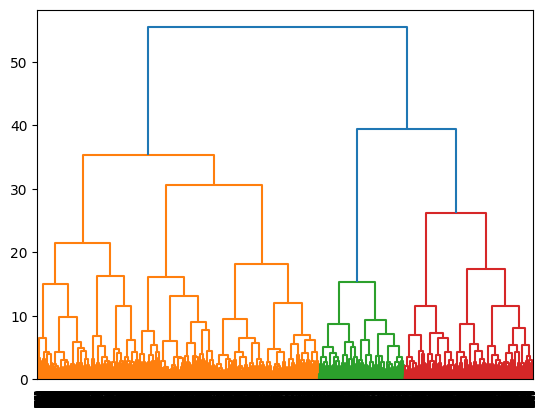

In [9]:
# Dendrogram plot using linkage matrix
linkage_matrix = linkage(X_sample, 'ward')

dendrogram(linkage_matrix)
plt.show()

#### Distribution of Classes in Every Claster

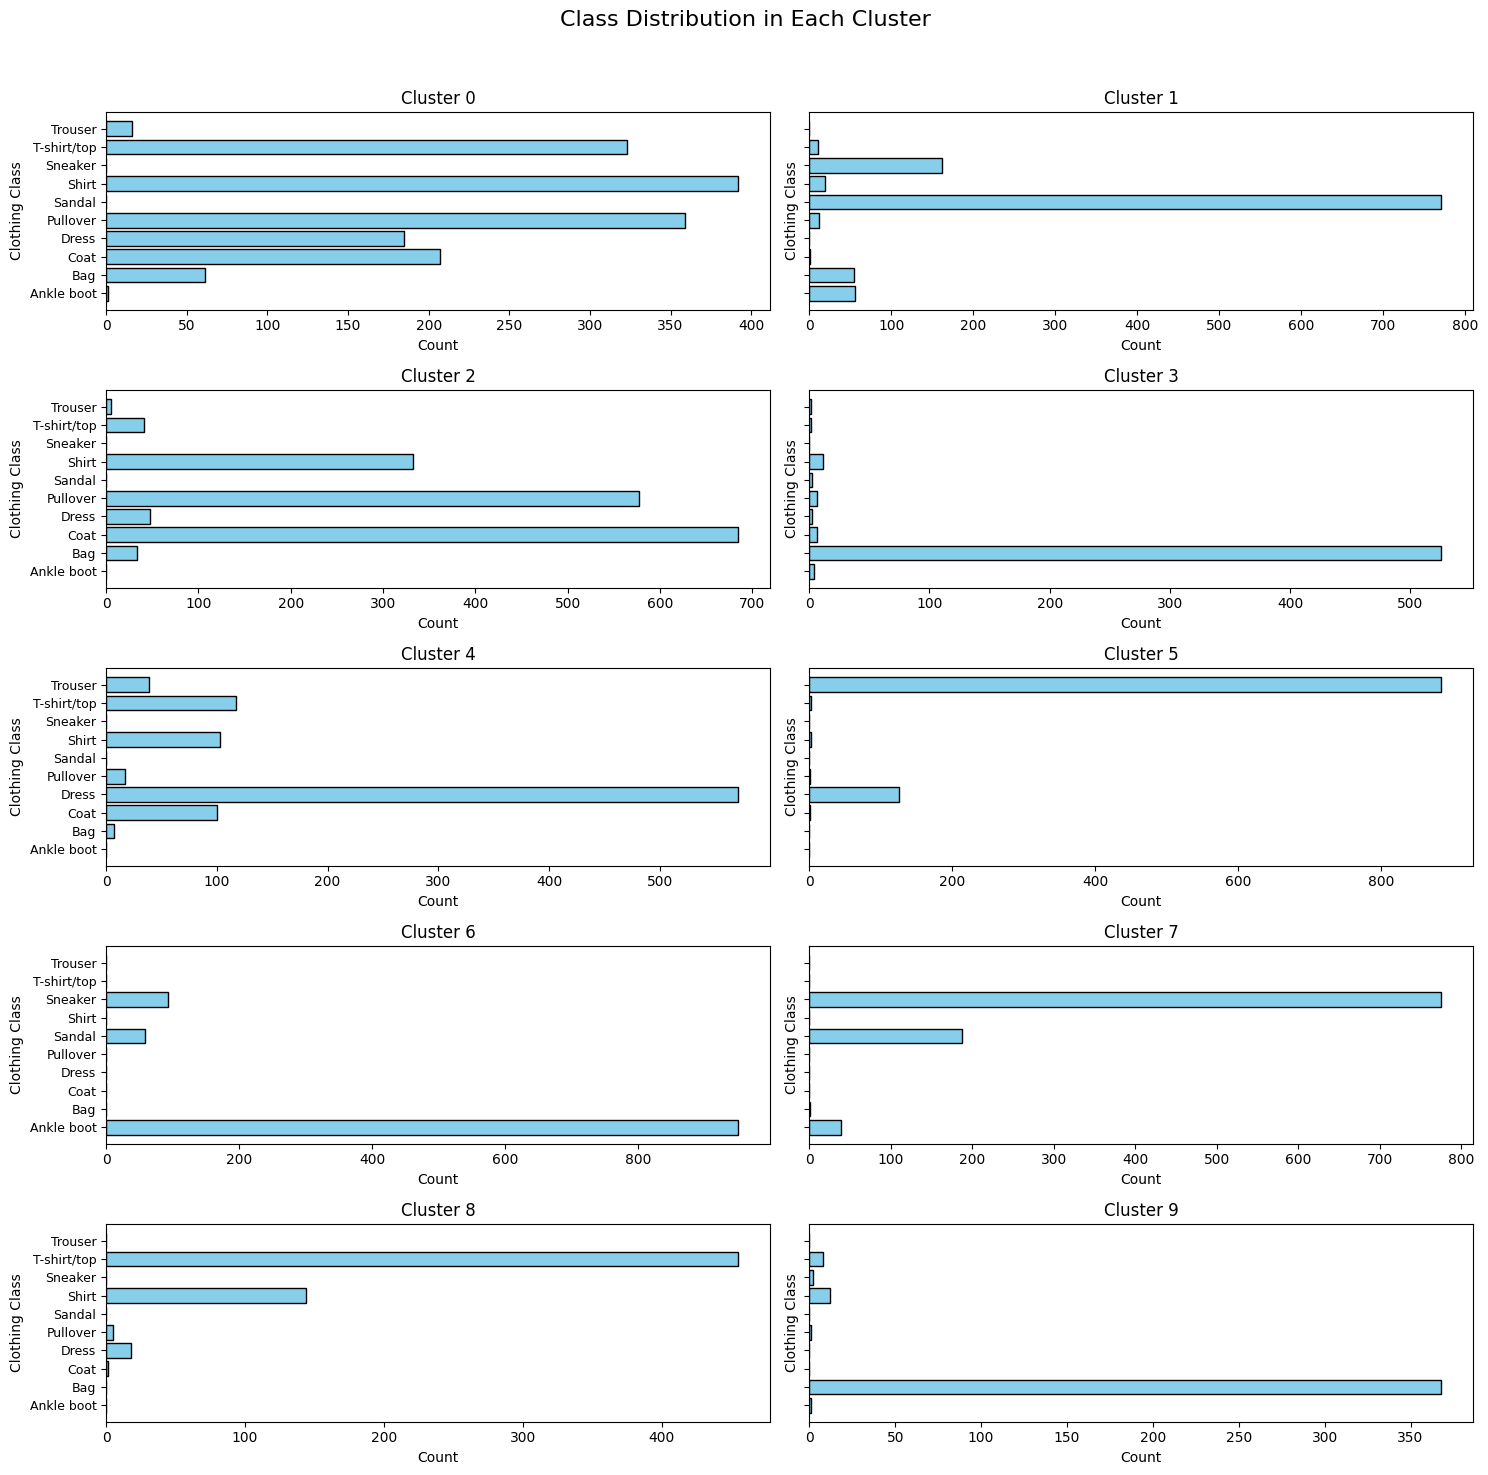

In [10]:
# Data preparation
analysis_data = pd.DataFrame({'True Labels': Y_sample, 'Cluster Labels': clustering_labels["euclidean_ward"]})
analysis_data['Clothing Classes'] = analysis_data['True Labels'].map(labels_mapping)

# Class counts for each cluster
class_counts_data = analysis_data.groupby(['Cluster Labels', 'Clothing Classes']).size().unstack(fill_value=0)

num_clusters = class_counts_data.shape[0]
rows = (num_clusters + 1) // 2
fig, axs = plt.subplots(nrows=rows, ncols=2, figsize=(15, rows * 3), sharey=True)
fig.suptitle('Class Distribution in Each Cluster', fontsize=16)

# Flatten axs
axs = axs.ravel()

# Plot
for idx, cluster_label in enumerate(class_counts_data.index):
    cluster_data = class_counts_data.loc[cluster_label].sort_index()
    ax = axs[idx]
    ax.barh(cluster_data.index, cluster_data.values, color="skyblue", edgecolor="black")
    ax.set_title(f'Cluster {cluster_label}', fontsize=12)
    ax.set_xlabel('Count')
    ax.set_ylabel('Clothing Class')
    ax.tick_params(axis='y', labelsize=9)

for ax in axs[num_clusters:]:
    ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


### Kmeans Clustering


In [33]:
# Kmeans clustering
kmeans = KMeans(n_clusters=10, n_init="auto").fit(X)
kmeans.labels_

adjusted_rand_score(Y, kmeans.labels_)

0.435729232174788

#### Kmeans with reduced dimensiality


In [34]:
# Data dimensionality reduction using PCA
pca = PCA(n_components=273)
data_pca_transformed = pca.fit_transform(X)

# Adding column names
data_pca = pd.DataFrame(
    data_pca_transformed,
    columns=[f'PC {i}' for i in range(1, 274)]
)

# Adding labels
data_pca["label"] = Y

# Reducing data
X_reduced = data_pca.drop("label", axis=1)

# Kmeans Clustering
kmeans = KMeans(n_clusters=10, random_state=42, n_init="auto")
kmeans.fit(X_reduced)

data_pca["Cluster_Labels"] = kmeans.labels_

adjusted_rand_score_value = adjusted_rand_score(Y, kmeans.labels_)
print(adjusted_rand_score_value)

0.4089831072488897


In [35]:
# Grouping clustered data
grouped_by_cluster = data_pca.groupby("Cluster_Labels")

class_counts_by_cluster = grouped_by_cluster["label"].value_counts()

class_counts_by_cluster

Cluster_Labels  label
0               8        2119
                4          33
                3          30
                0          28
                2          24
                         ... 
9               1          58
                3          58
                8          31
                5          24
                9          22
Name: count, Length: 84, dtype: int64

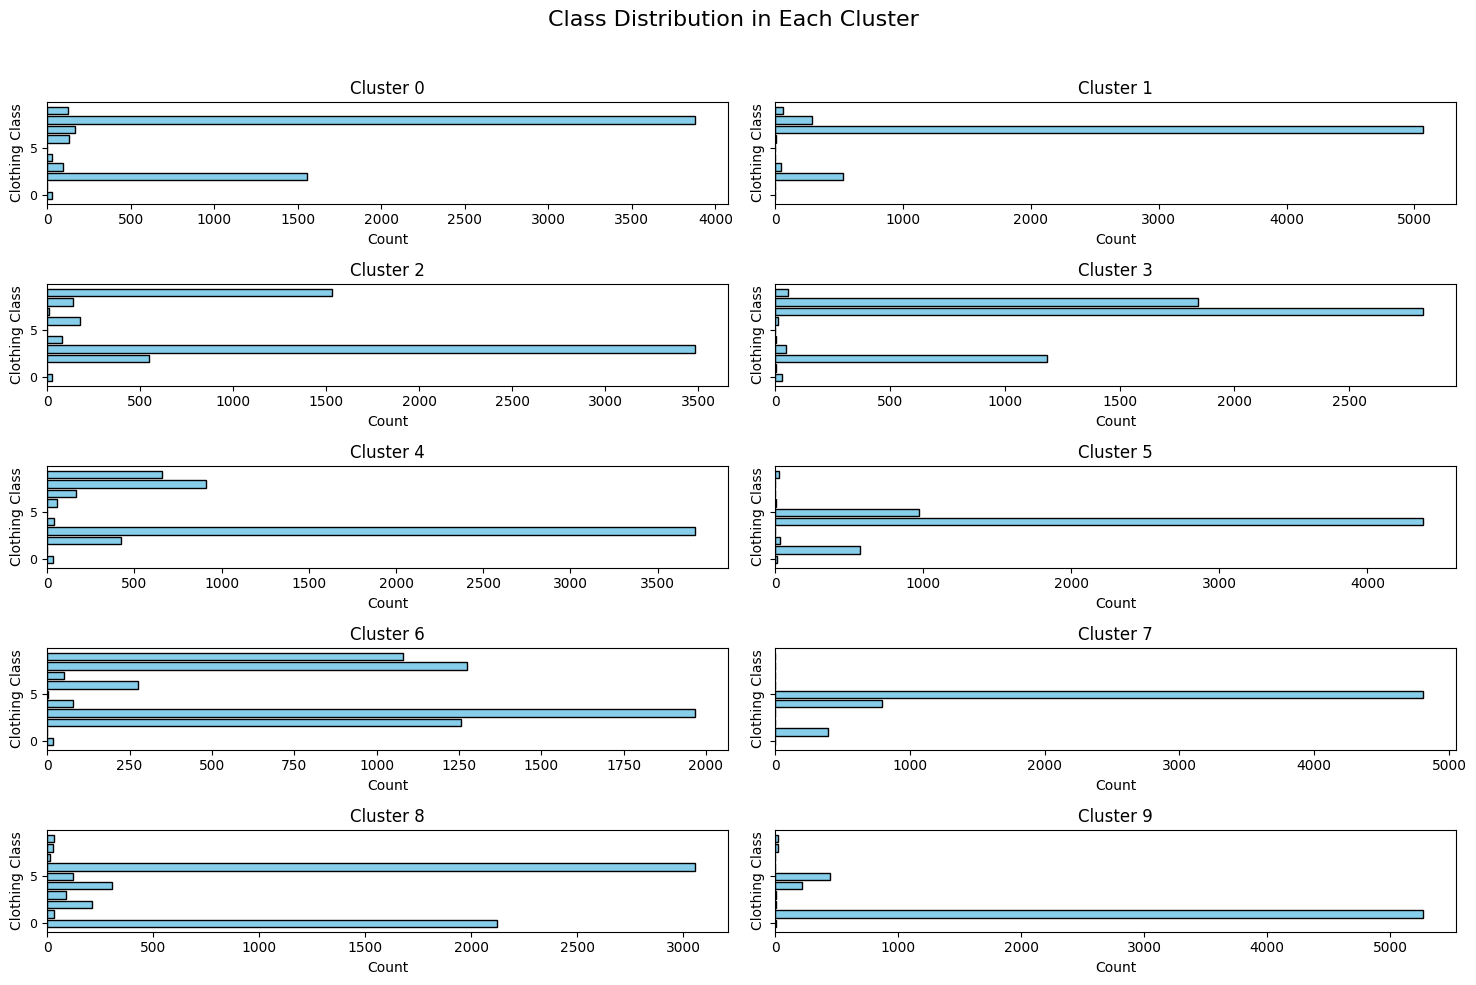

In [36]:
# Class counts for each cluster
class_counts_data = class_counts_by_cluster.unstack()

fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 10), sharey=True)
fig.suptitle('Class Distribution in Each Cluster', fontsize=16)

# Flatten axs
axs = axs.ravel()

# Plot
for idx, cluster_label in enumerate(class_counts_data.columns):
    cluster_data = class_counts_data[cluster_label].fillna(0).sort_index()
    ax = axs[idx]

    ax.barh(cluster_data.index, cluster_data.values, color="skyblue", edgecolor="black")
    ax.set_title(f'Cluster {cluster_label}', fontsize=12)
    ax.set_xlabel('Count')
    ax.set_ylabel('Clothing Class')
    ax.tick_params(axis='y', labelsize=9)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


### DBSCAN Clustering

In [22]:
# DBSCAN Clustering
dbscan = DBSCAN().fit(X)

print(np.unique(dbscan.labels_))
dbscan_labels = dbscan.labels_

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
 47 48 49 50 51 52 53 54 55 56 57 58 59 60]


In [23]:
adjusted_rand_score = adjusted_rand_score(Y, dbscan_labels)
print(adjusted_rand_score)

0.032385130051581806


In [24]:
dbscan_labels_data = pd.DataFrame({'DBSCAN_Labels': dbscan_labels})

data_concat = pd.concat([X, dbscan_labels_data], axis=1)

# Grouped DBSCAN labels
dbscan_groups = data_concat.groupby('DBSCAN_Labels')

for label, group in dbscan_groups:
    print(f"Counts for DBSCAN label {label}: {len(group)}")

Counts for DBSCAN label -1: 27385
Counts for DBSCAN label 0: 31719
Counts for DBSCAN label 1: 464
Counts for DBSCAN label 2: 2
Counts for DBSCAN label 3: 18
Counts for DBSCAN label 4: 13
Counts for DBSCAN label 5: 7
Counts for DBSCAN label 6: 21
Counts for DBSCAN label 7: 11
Counts for DBSCAN label 8: 12
Counts for DBSCAN label 9: 6
Counts for DBSCAN label 10: 11
Counts for DBSCAN label 11: 19
Counts for DBSCAN label 12: 5
Counts for DBSCAN label 13: 5
Counts for DBSCAN label 14: 4
Counts for DBSCAN label 15: 10
Counts for DBSCAN label 16: 5
Counts for DBSCAN label 17: 12
Counts for DBSCAN label 18: 4
Counts for DBSCAN label 19: 19
Counts for DBSCAN label 20: 5
Counts for DBSCAN label 21: 4
Counts for DBSCAN label 22: 5
Counts for DBSCAN label 23: 8
Counts for DBSCAN label 24: 10
Counts for DBSCAN label 25: 9
Counts for DBSCAN label 26: 23
Counts for DBSCAN label 27: 5
Counts for DBSCAN label 28: 8
Counts for DBSCAN label 29: 8
Counts for DBSCAN label 30: 5
Counts for DBSCAN label 31: 

#### DBSCAN with reduced dimensionality


In [78]:
# Reducing dimensionality with PCA
data_pca = PCA(n_components=273).fit_transform(X)

# Adding columns
data_pca = pd.DataFrame(data_pca, columns=[f'PC {i}' for i in range(1, 274)])

# Adding labels
data_pca["label"] = Y

X_reduced = data_pca.iloc[:, :-1]

# DBSCAN clusterring
dbscan = DBSCAN()
dbscan_labels = dbscan.fit_predict(X_reduced)

adjusted_rand_score = adjusted_rand_score(Y, dbscan_labels)
print(adjusted_rand_score)

0.015823183704870236


In [28]:
dbscan_labels_data = pd.DataFrame({'DBSCAN_Labels': dbscan_labels})

data_concat = pd.concat([data_pca, dbscan_labels_data], axis=1)

# Grouped DBSCAN labels
dbscan_groups = data_concat.groupby('DBSCAN_Labels')

for label, group in dbscan_groups:
    print(f"Counts for DBSCAN label {label}: {len(group)}")


Counts for DBSCAN label -1: 17832
Counts for DBSCAN label 0: 41880
Counts for DBSCAN label 1: 52
Counts for DBSCAN label 2: 5
Counts for DBSCAN label 3: 9
Counts for DBSCAN label 4: 53
Counts for DBSCAN label 5: 13
Counts for DBSCAN label 6: 8
Counts for DBSCAN label 7: 9
Counts for DBSCAN label 8: 5
Counts for DBSCAN label 9: 3
Counts for DBSCAN label 10: 6
Counts for DBSCAN label 11: 6
Counts for DBSCAN label 12: 5
Counts for DBSCAN label 13: 7
Counts for DBSCAN label 14: 4
Counts for DBSCAN label 15: 4
Counts for DBSCAN label 16: 5
Counts for DBSCAN label 17: 7
Counts for DBSCAN label 18: 6
Counts for DBSCAN label 19: 8
Counts for DBSCAN label 20: 5
Counts for DBSCAN label 21: 14
Counts for DBSCAN label 22: 5
Counts for DBSCAN label 23: 5
Counts for DBSCAN label 24: 6
Counts for DBSCAN label 25: 7
Counts for DBSCAN label 26: 4
Counts for DBSCAN label 27: 2
Counts for DBSCAN label 28: 6
Counts for DBSCAN label 29: 5
Counts for DBSCAN label 30: 5
Counts for DBSCAN label 31: 5
Counts f

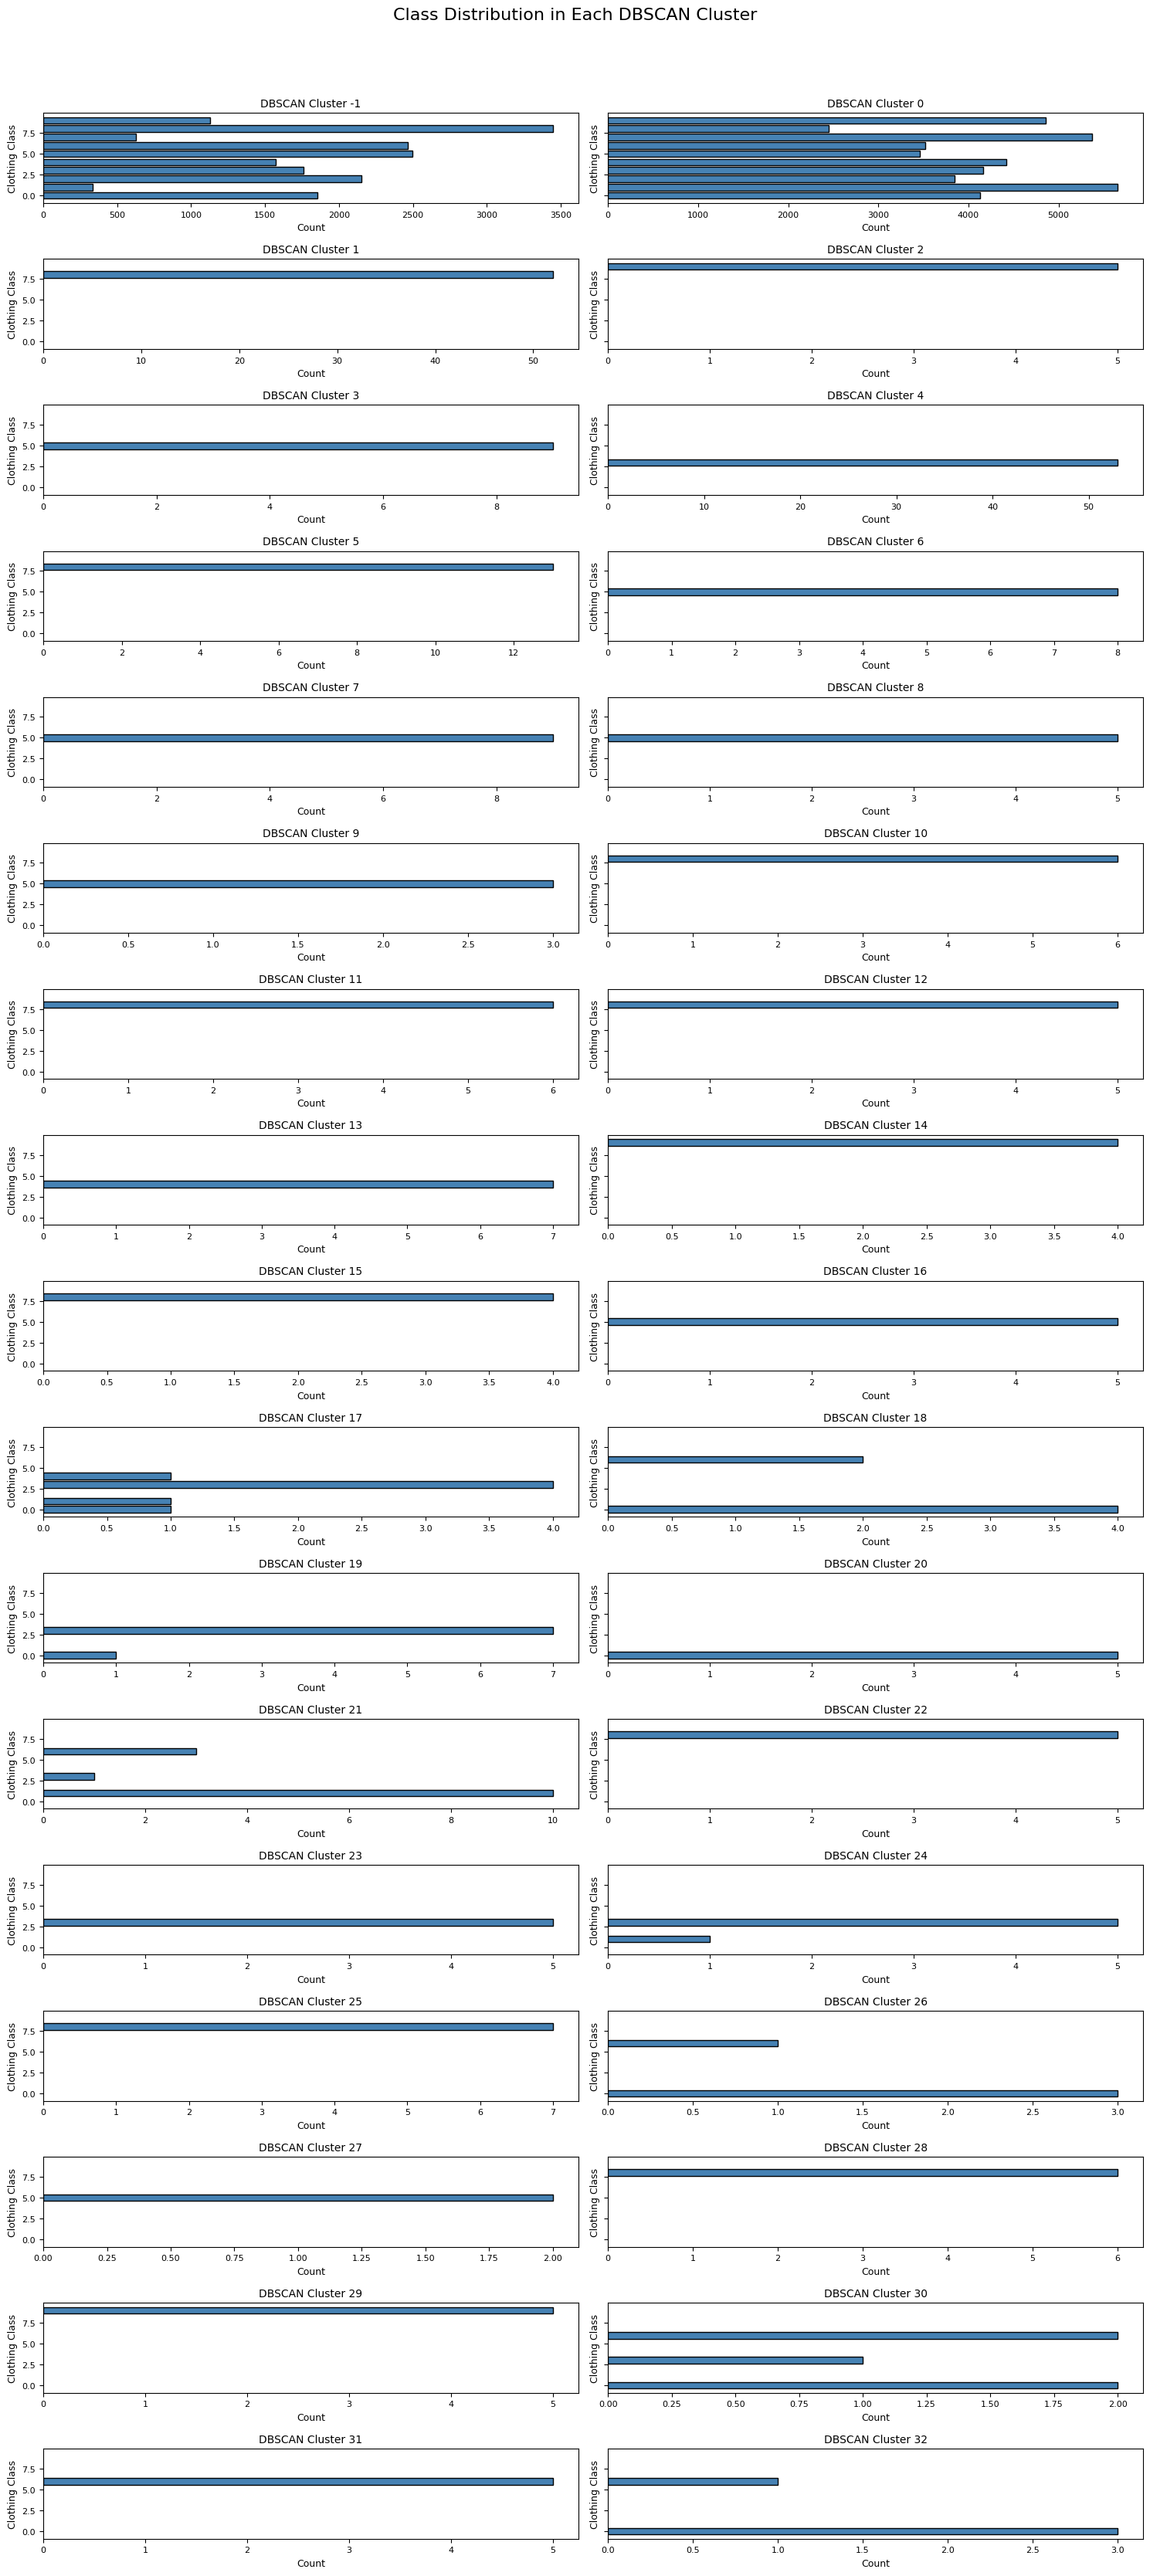

In [29]:
num_clusters = len(dbscan_groups.groups)
rows = (num_clusters + 1) // 2

fig, axs = plt.subplots(rows, 2, figsize=(15, rows * 2), sharey=True)
fig.suptitle('Class Distribution in Each DBSCAN Cluster', fontsize=16)

# Flatten axes
axs = axs.ravel()

# Plot
for i, (label, ax) in enumerate(zip(dbscan_groups.groups.keys(), axs)):
    cluster_data = dbscan_groups.get_group(label)['label'].value_counts().sort_index()

    ax.barh(cluster_data.index, cluster_data.values, color='steelblue', edgecolor='black')

    ax.set_title(f'DBSCAN Cluster {label}', fontsize=10)
    ax.set_xlabel('Count', fontsize=9)
    ax.set_ylabel('Clothing Class', fontsize=9)
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)

for ax in axs[i + 1:]:
    ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

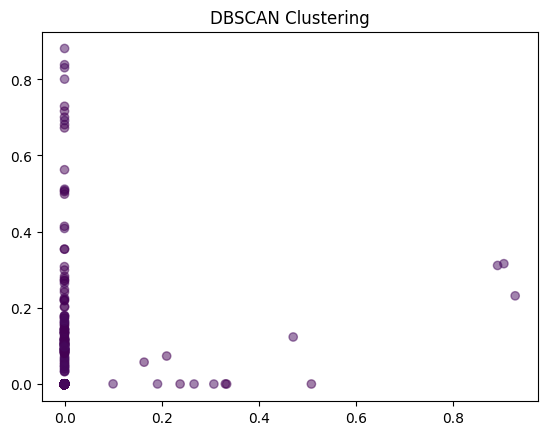

In [30]:
# Plot DBSCAN clustering results
plt.scatter(
    X.values[:, 0],
    X.values[:, 1],
    c=dbscan_labels,
    cmap='viridis',
    alpha=0.5
)

plt.title("DBSCAN Clustering")

plt.show()

#### DBSCAN other parameters


In [27]:

# Reducing dimensionality with PCA
data_pca = PCA(n_components=273).fit_transform(X)

# Adding columns
data_pca = pd.DataFrame(data_pca, columns=[f'PC {i}' for i in range(1, 274)])

# Adding labels
data_pca["label"] = Y

X_reduced = data_pca.iloc[:, :-1]

# DBSCAN clusterring
dbscan = DBSCAN(eps=0.587, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_reduced)

adjusted_rand_score = adjusted_rand_score(Y, dbscan_labels)
print(adjusted_rand_score)

0.0037072745494427703


In [28]:
dbscan_labels_data = pd.DataFrame({'DBSCAN_Labels': dbscan_labels})

data_concat = pd.concat([data_pca, dbscan_labels_data], axis=1)

# Grouped DBSCAN labels
dbscan_groups = data_concat.groupby('DBSCAN_Labels')

for label, group in dbscan_groups:
    print(f"Counts for DBSCAN label {label}: {len(group)}")

Counts for DBSCAN label -1: 8248
Counts for DBSCAN label 0: 51679
Counts for DBSCAN label 1: 3
Counts for DBSCAN label 2: 5
Counts for DBSCAN label 3: 7
Counts for DBSCAN label 4: 5
Counts for DBSCAN label 5: 5
Counts for DBSCAN label 6: 3
Counts for DBSCAN label 7: 9
Counts for DBSCAN label 8: 6
Counts for DBSCAN label 9: 4
Counts for DBSCAN label 10: 3
Counts for DBSCAN label 11: 4
Counts for DBSCAN label 12: 6
Counts for DBSCAN label 13: 4
Counts for DBSCAN label 14: 5
Counts for DBSCAN label 15: 4


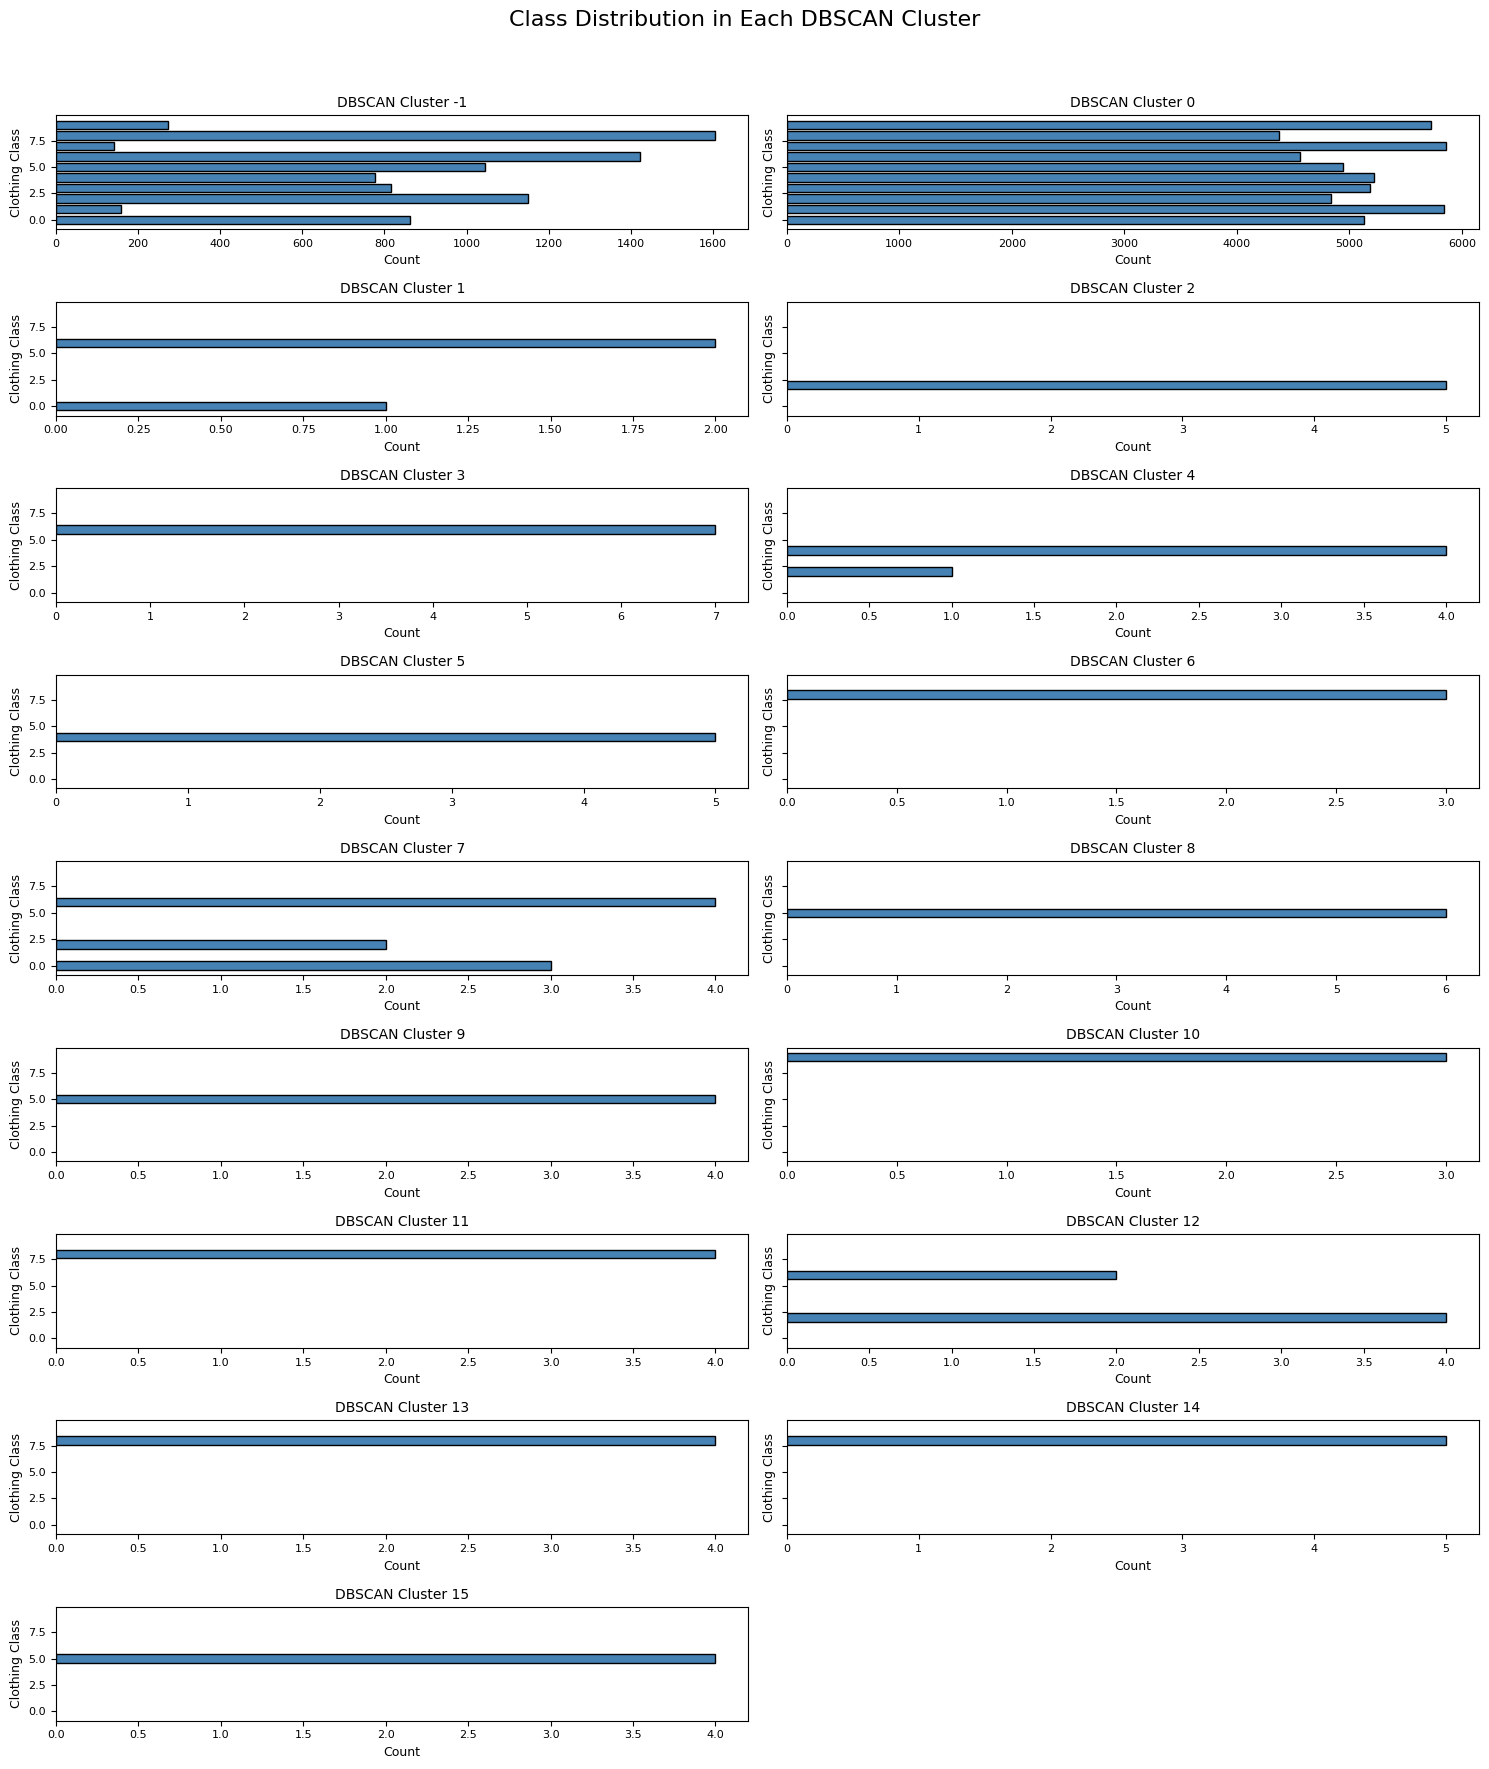

In [29]:
num_clusters = len(dbscan_groups.groups)
rows = (num_clusters + 1) // 2

fig, axs = plt.subplots(rows, 2, figsize=(15, rows * 2), sharey=True)
fig.suptitle('Class Distribution in Each DBSCAN Cluster', fontsize=16)

# Flatten axes
axs = axs.ravel()

# Plot
for i, (label, ax) in enumerate(zip(dbscan_groups.groups.keys(), axs)):
    cluster_data = dbscan_groups.get_group(label)['label'].value_counts().sort_index()

    ax.barh(cluster_data.index, cluster_data.values, color='steelblue', edgecolor='black')

    ax.set_title(f'DBSCAN Cluster {label}', fontsize=10)
    ax.set_xlabel('Count', fontsize=9)
    ax.set_ylabel('Clothing Class', fontsize=9)
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)

for ax in axs[i + 1:]:
    ax.axis('off')


plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

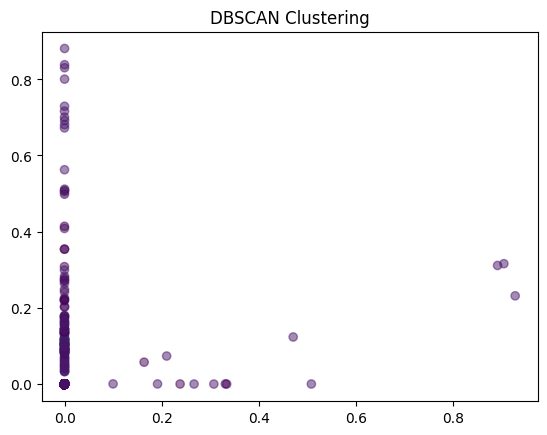

In [30]:
# Plot DBSCAN clustering results
plt.scatter(
    X.values[:, 0],
    X.values[:, 1],
    c=dbscan_labels,
    cmap='viridis',
    alpha=0.5
)

plt.title("DBSCAN Clustering")

plt.show()

### Gausian Mixture Models

In [39]:
# Gaussian Mixture Model
gmm = GaussianMixture(
    n_components=10,
    random_state=42
)

gmm.fit(X)

cluster_labels_gmm = gmm.predict(X)

adjusted_rand_score = adjusted_rand_score(Y, cluster_labels_gmm)
print(adjusted_rand_score)

0.37075665521604695


In [40]:
# Data preparation
gmm_data = X.copy()
gmm_data['GMM_Labels'] = cluster_labels_gmm

gmm_groups = gmm_data.groupby('GMM_Labels')

# Number of unique GMM labels
num_gmm_labels = gmm_groups.ngroups
print(f"Number of different GMM labels: {num_gmm_labels}")

# Number of samples for each GMM label
gmm_label_counts = {label: len(group) for label, group in gmm_groups}

for label, count in gmm_label_counts.items():
    print(f"Counts for GMM label {label}: {count}")

Number of different GMM labels: 10
Counts for GMM label 0: 2052
Counts for GMM label 1: 10748
Counts for GMM label 2: 2855
Counts for GMM label 3: 4056
Counts for GMM label 4: 9293
Counts for GMM label 5: 5552
Counts for GMM label 6: 7748
Counts for GMM label 7: 3681
Counts for GMM label 8: 5386
Counts for GMM label 9: 8629


### GMM with reduced dimensionality


In [41]:
# PCA reduced dimensionality
data_pca = PCA(n_components=273).fit_transform(X)

# Adding column names
data_pca = pd.DataFrame(
    data_pca,
    columns=[f'PC {i}' for i in range(1, 274)]
)

# Adding labels
data_pca["label"] = Y

X_reduced = data_pca.iloc[:, :-1]

gmm = GaussianMixture(
    n_components=10,
    random_state=42
)
gmm.fit(X_reduced)

# Cluster labels for transformed data
cluster_labels_gmm = gmm.predict(X_reduced)

cluster_labels_gmm

array([6, 5, 3, ..., 2, 6, 5])

In [49]:
adjusted_rand_score = adjusted_rand_score(Y, cluster_labels_gmm)
print(adjusted_rand_score)

0.39155674408620367


In [42]:
data_gmm = pd.DataFrame({'GMM_Labels': cluster_labels_gmm})

# Concatenated data
data_pca_with_gmm = pd.concat([data_pca, data_gmm], axis=1)

gmm_groups = data_pca_with_gmm.groupby('GMM_Labels')

# Number of unique GMM labels
print("Number of different GMM labels:", len(gmm_groups))

for label, group in gmm_groups:
    print(f"Counts for GMM label {label}: {len(group)}")

Number of different GMM labels: 10
Counts for GMM label 0: 2172
Counts for GMM label 1: 4524
Counts for GMM label 2: 8064
Counts for GMM label 3: 8787
Counts for GMM label 4: 3108
Counts for GMM label 5: 10126
Counts for GMM label 6: 4093
Counts for GMM label 7: 9183
Counts for GMM label 8: 5028
Counts for GMM label 9: 4915


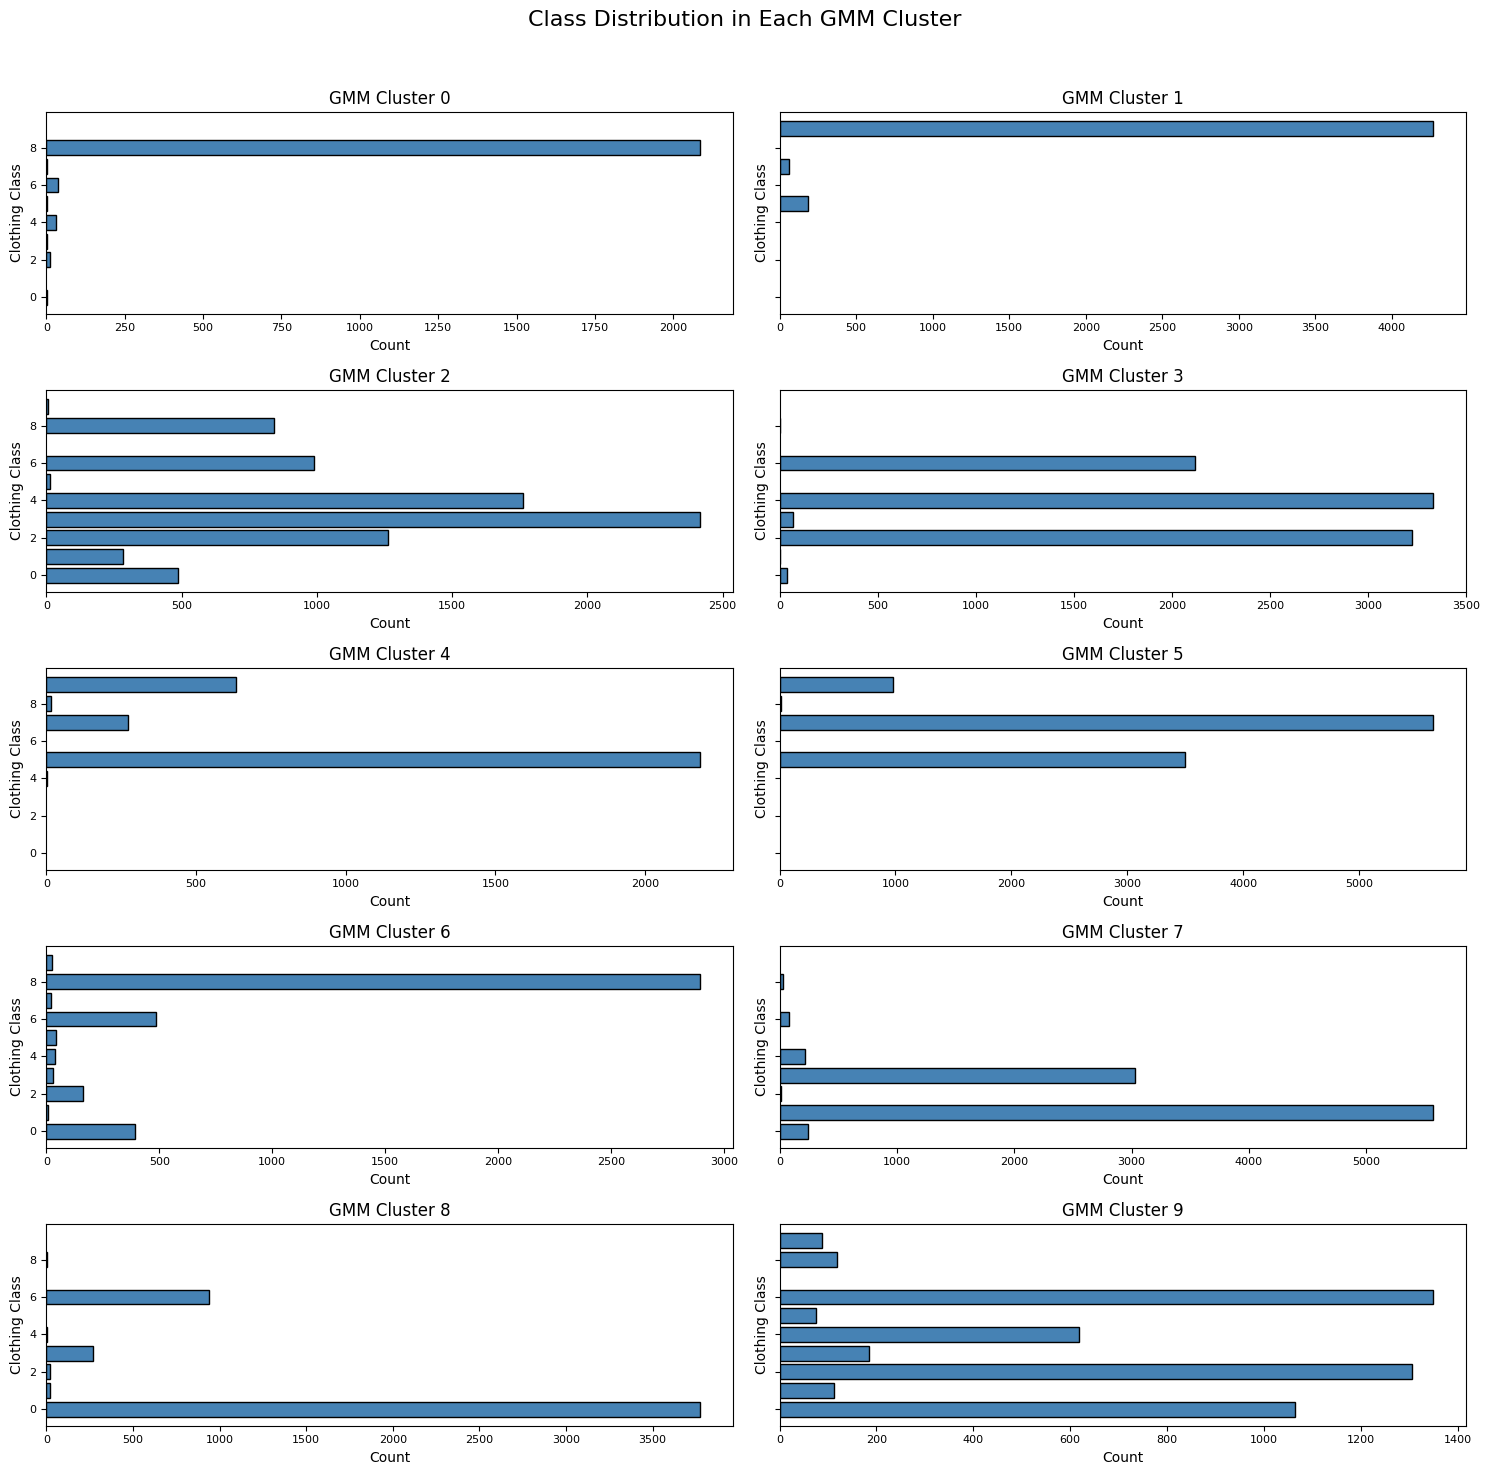

In [43]:
n_clusters = len(gmm_groups.groups.keys())
n_rows = (n_clusters + 1) // 2
n_cols = 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 3), sharey=True)
fig.suptitle('Class Distribution in Each GMM Cluster', fontsize=16)

# Flatten axes
axes = axes.ravel()

# Plot
for idx, (label, group) in enumerate(gmm_groups):
    cluster_data = group['label'].value_counts().sort_index()

    axes[idx].barh(cluster_data.index, cluster_data.values, color='steelblue', edgecolor='black')

    axes[idx].set_title(f'GMM Cluster {label}', fontsize=12)
    axes[idx].set_xlabel('Count', fontsize=10)
    axes[idx].set_ylabel('Clothing Class', fontsize=10)
    axes[idx].tick_params(axis='x', labelsize=8)
    axes[idx].tick_params(axis='y', labelsize=8)

for ax in axes[len(gmm_groups):]:
    ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Classification

In [43]:
# Data import
dataset = pd.read_csv('./data/fashion-mnist_train.csv')

# Data preporcessing
X =  dataset.iloc[:,1:]
Y = dataset.iloc[:,0]

# Label names numbers
class_labels_mapping = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

labels = pd.DataFrame(dataset['label'])

#### K-nearest Neighbours

In [44]:
# Config values
KNN_CONFIG = {
    "leaf_size": 20,
    "metric": 'minkowski',
    "neighbors": 10,
    "p": 2,
    "weights": "uniform"
}

Fold 1: Train indices: [12000 12001 12002 ... 59997 59998 59999], Test indices: [    0     1     2 ... 11997 11998 11999]
[ Fold 1 ]: Score = 0.8634166666666667


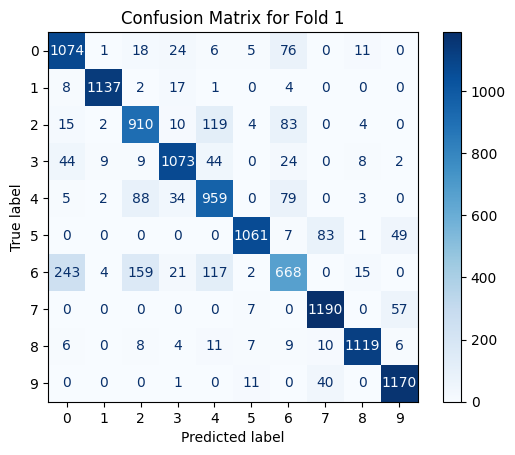

Fold 2: Train indices: [    0     1     2 ... 59997 59998 59999], Test indices: [12000 12001 12002 ... 23997 23998 23999]
[ Fold 2 ]: Score = 0.86475


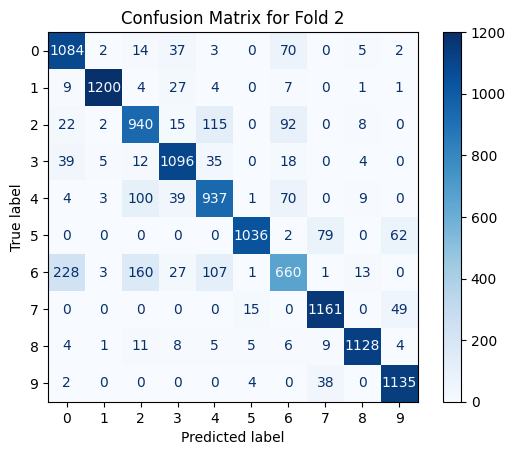

Fold 3: Train indices: [    0     1     2 ... 59997 59998 59999], Test indices: [24000 24001 24002 ... 35997 35998 35999]
[ Fold 3 ]: Score = 0.8625


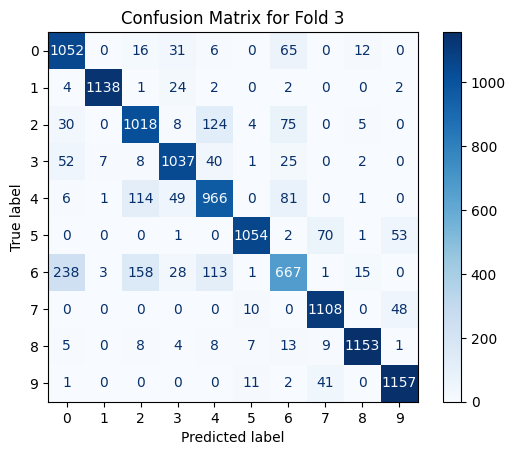

Fold 4: Train indices: [    0     1     2 ... 59997 59998 59999], Test indices: [36000 36001 36002 ... 47997 47998 47999]
[ Fold 4 ]: Score = 0.8575833333333334


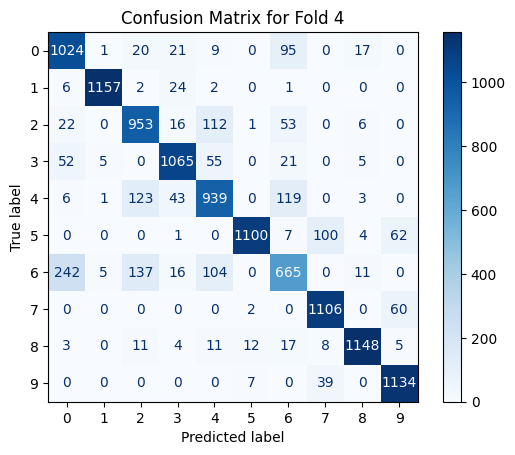

Fold 5: Train indices: [    0     1     2 ... 47997 47998 47999], Test indices: [48000 48001 48002 ... 59997 59998 59999]
[ Fold 5 ]: Score = 0.8603333333333333


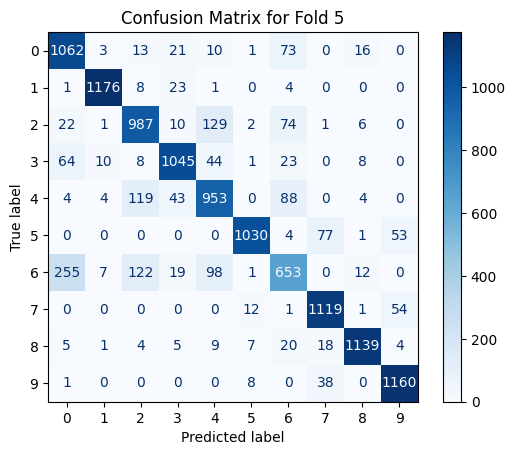

Fold Accuracies: [0.8634166666666667, 0.86475, 0.8625, 0.8575833333333334, 0.8603333333333333]
Average Accuracy: 0.8617166666666666


In [45]:
scaler = StandardScaler()
kfold = KFold(n_splits=5)
fold_accuracies = []

# Splitting data
for fold, (train_idx, test_idx) in enumerate(kfold.split(X), start=1):

    # Debugging information
    print(f"Fold {fold}: Train indices: {train_idx}, Test indices: {test_idx}")

    # Scaling
    X_train_scaled = scaler.fit_transform(X.iloc[train_idx])
    X_test_scaled = scaler.transform(X.iloc[test_idx])

    # Normalizing
    X_train_normalized = normalize(X_train_scaled)
    X_test_normalized = normalize(X_test_scaled)

    # KNN classification
    knn_classifier = KNeighborsClassifier(
        leaf_size=KNN_CONFIG["leaf_size"],
        metric=KNN_CONFIG["metric"],
        n_neighbors=KNN_CONFIG["neighbors"],
        p=KNN_CONFIG["p"],
        weights=KNN_CONFIG["weights"],
        n_jobs=-1
    )

    # KNN model
    knn_classifier.fit(X_train_normalized, Y.iloc[train_idx])

    # Accuracy
    Y_pred = knn_classifier.predict(X_test_normalized)
    fold_score = knn_classifier.score(X_test_normalized, Y.iloc[test_idx])
    print(f"[ Fold {fold} ]: Score = {fold_score}")
    fold_accuracies.append(fold_score)

    # Confusion matrix
    cm = confusion_matrix(Y.iloc[test_idx], Y_pred, labels=knn_classifier.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn_classifier.classes_)
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix for Fold {fold}")
    plt.show()

print("Fold Accuracies:", fold_accuracies)
print(f"Average Accuracy: {sum(fold_accuracies) / len(fold_accuracies)}")


#### Extreme Gradient Boosting

Accuracy: 0.9015


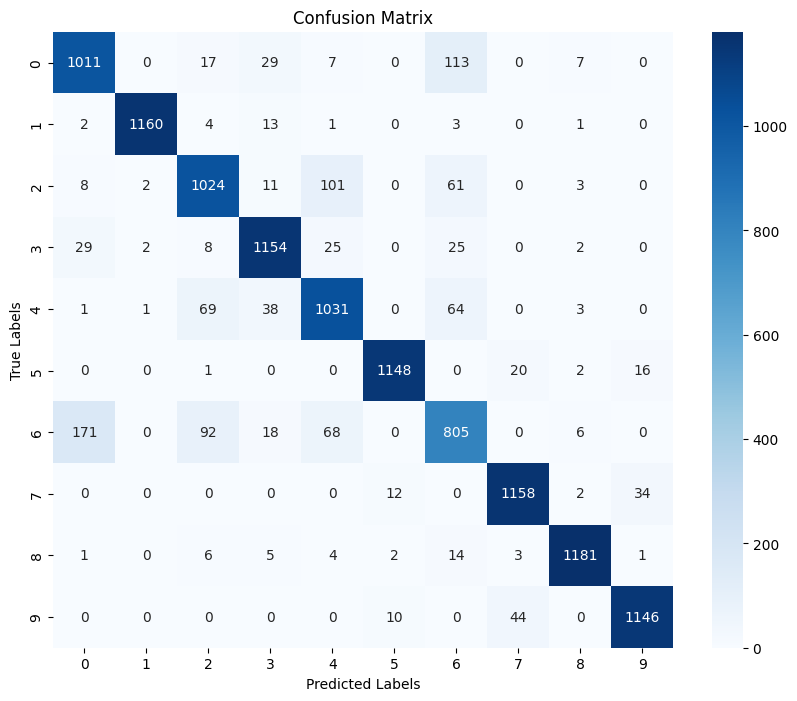

In [46]:
# Splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=10)

# XGBoost Classifier
xg_clf = xgb.XGBClassifier(objective='multi:softmax', num_class=10, random_state=10)

# XGBoost model
xg_clf.fit(x_train, y_train)

predictions = xg_clf.predict(x_test)

accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, predictions)
plt.figure(figsize=(10, 8))
seaborn.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### Decision trees


In [47]:
def plot_decision_tree(tree, figsize=(20,10)):
    fig, ax = plt.subplots(figsize=figsize)
    plot_tree(tree, ax=ax)
    plt.show()

In [48]:
# Spliting data
x_train, x_test, y_train, y_test = train_test_split(
    X,
    Y,
    test_size=0.20,       # 20% of data for testing
    random_state=10
)

# Decision Tree Classifier
decision_tree = DecisionTreeClassifier(
    criterion='gini',
    random_state=10
)

decision_tree.fit(x_train, y_train)

test_score = decision_tree.score(x_test, y_test)
test_score


0.7935

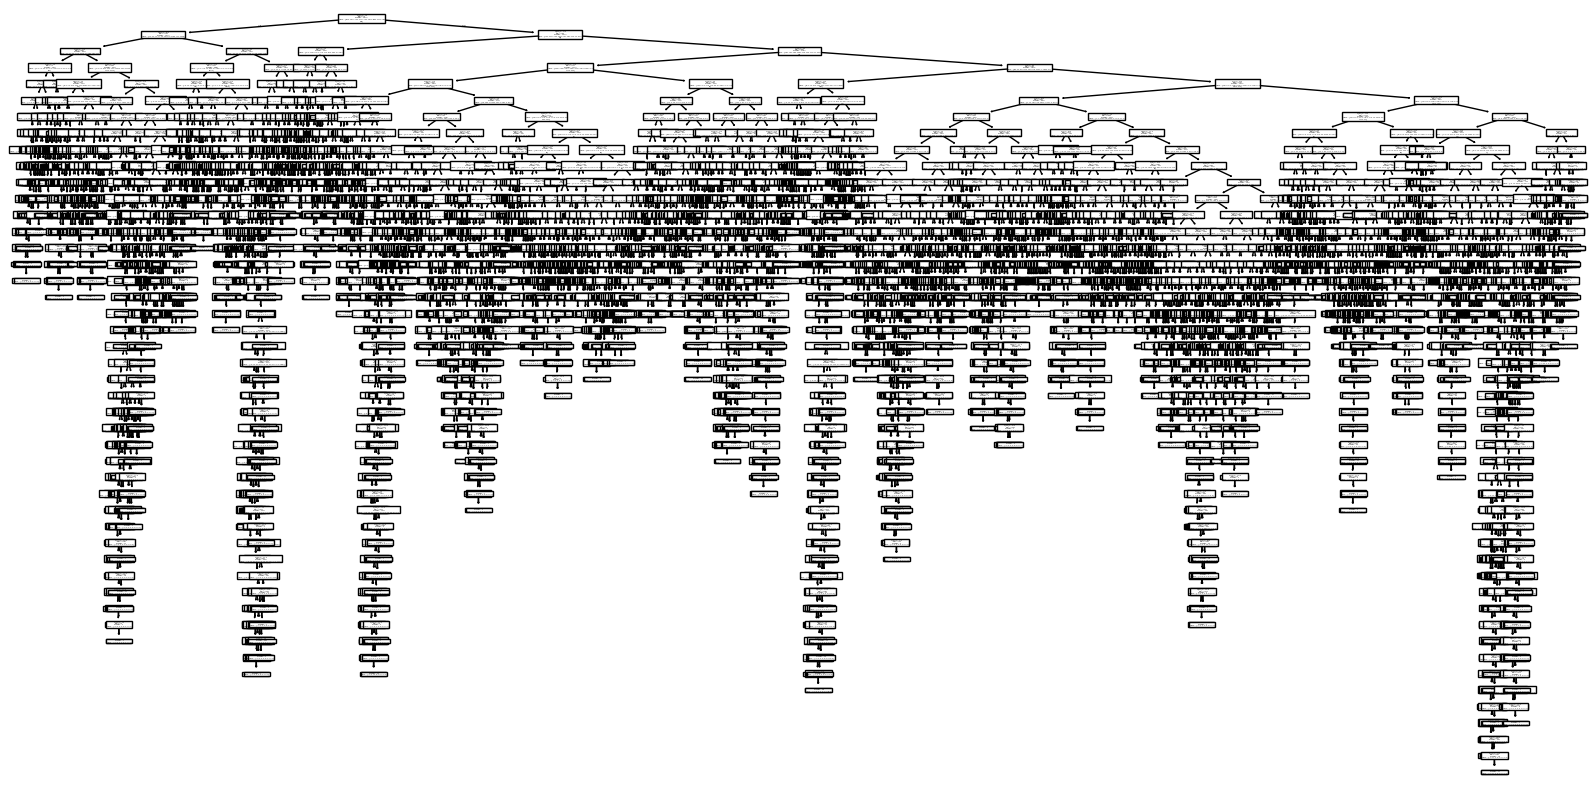

In [49]:
plot_decision_tree(tree=decision_tree)

In [50]:
# Splitting data
x_train, x_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.20, random_state=10
)

# Random Forest Classifier
forest = RandomForestClassifier(
    n_estimators=100,
    random_state=10,
    n_jobs=-1
)

forest.fit(x_train, y_train)

predictions = forest.predict(x_test)

# Accuracy of the model
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8835


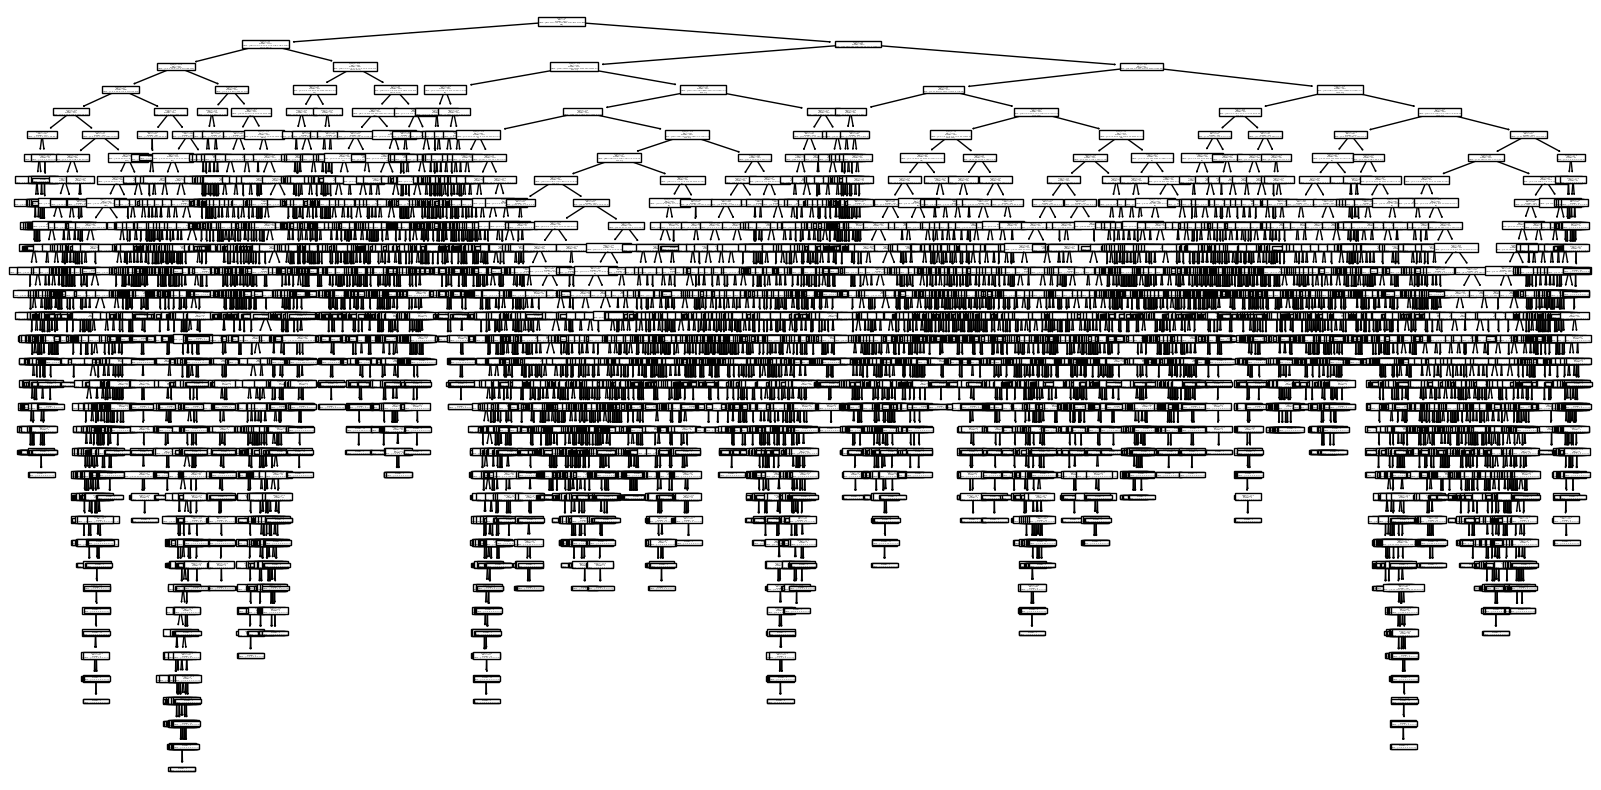

In [51]:
plot_decision_tree(tree=forest.estimators_[0])

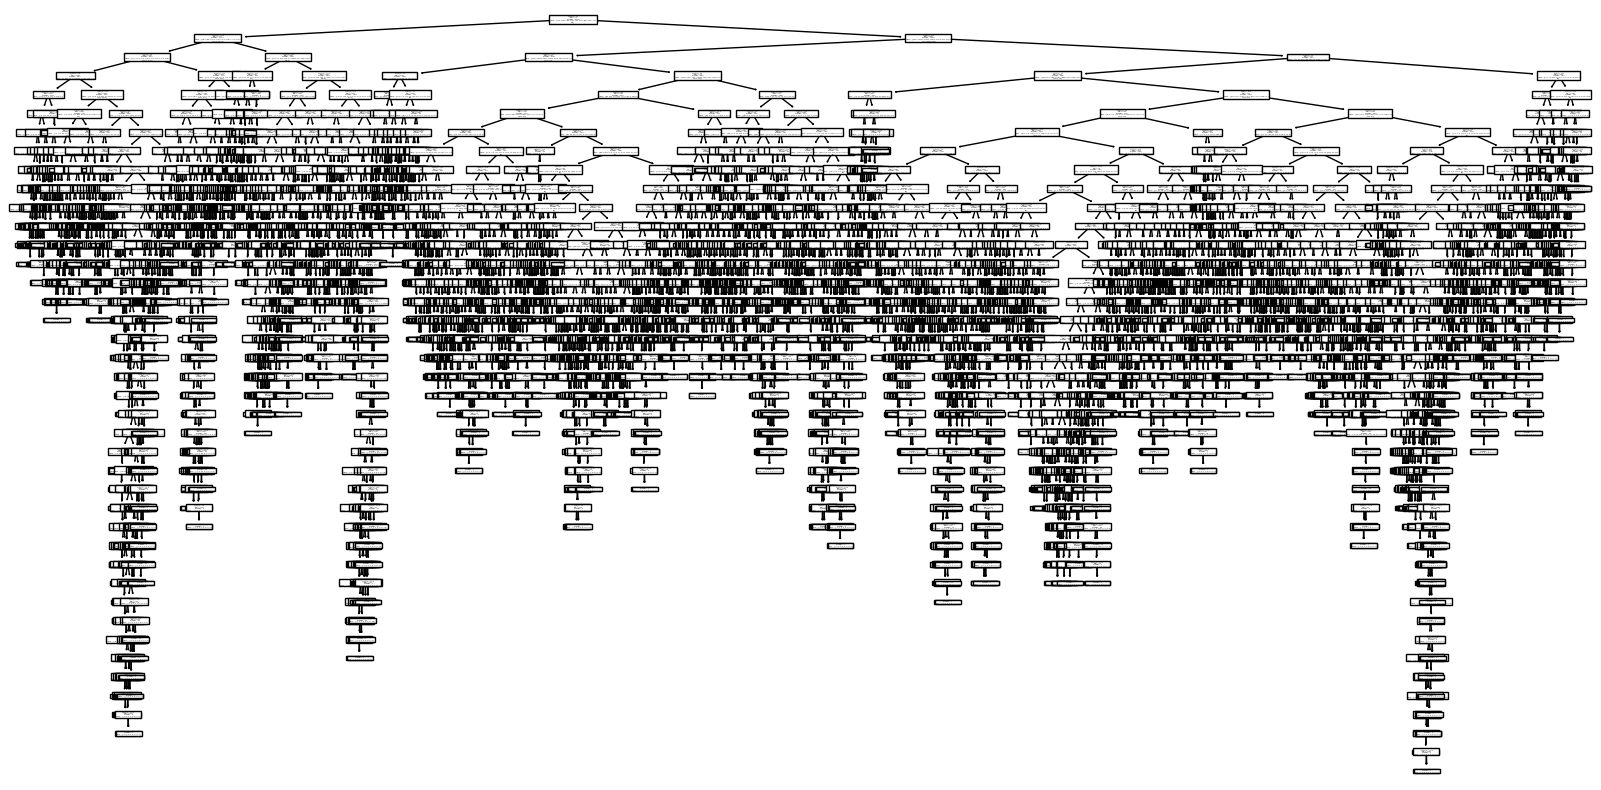

In [52]:
plot_decision_tree(tree=forest.estimators_[99])

In [53]:
importances = forest.feature_importances_
importances

array([0.00000000e+00, 6.60518648e-06, 2.00166145e-05, 2.57857232e-05,
       8.00494751e-05, 1.02168115e-04, 1.98786863e-04, 3.49690609e-04,
       4.10080292e-04, 6.90692072e-04, 2.31129294e-03, 1.16308499e-03,
       1.29432055e-03, 2.66269177e-03, 2.03403959e-03, 1.05187253e-03,
       7.92066786e-04, 2.24981670e-03, 1.19446755e-03, 4.27151795e-04,
       3.77317645e-04, 3.12608159e-04, 1.59818781e-04, 1.04843940e-04,
       7.96380377e-05, 1.79851068e-05, 4.59411961e-06, 2.26612828e-06,
       2.50478164e-06, 3.38061788e-06, 1.51972654e-05, 6.19887050e-05,
       1.19257280e-04, 2.35181769e-04, 3.29139200e-04, 9.86401598e-04,
       3.74665765e-03, 3.76699078e-03, 2.42197367e-03, 2.39273378e-03,
       3.87866554e-03, 1.40305357e-03, 1.68491683e-03, 1.01206825e-03,
       2.21468280e-03, 1.91775806e-03, 2.30718713e-03, 3.69894737e-03,
       2.09600349e-03, 6.93305688e-04, 2.63994311e-04, 2.80771447e-04,
       1.95044731e-04, 7.53960577e-05, 1.42778247e-05, 6.90364407e-07,
      